#Import Libraries

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"melanisafwa","key":"5fa217f6fea40a02a6b3eb26db42aae7"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

 98% 673M/688M [00:08<00:00, 112MB/s]
100% 688M/688M [00:08<00:00, 80.2MB/s]


In [ ]:
!unzip home-credit-default-risk.zip

Archive:  home-credit-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


In [ ]:
#import library modul yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np

# ML
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.metrics import accuracy_score, precision_score, log_loss, roc_auc_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier


#Load Dataset

In [ ]:
df_train = pd.read_csv('/content/application_train.csv')
df_test = pd.read_csv('/content/application_test.csv')

##Data Train

In [ ]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [ ]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [ ]:
df_train.shape

(307511, 122)

##Data Test

In [ ]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    NAME_CONTRACT_TYPE            object 
 2    CODE_GENDER                   object 
 3    FLAG_OWN_CAR                  object 
 4    FLAG_OWN_REALTY               object 
 5    CNT_CHILDREN                  int64  
 6    AMT_INCOME_TOTAL              float64
 7    AMT_CREDIT                    float64
 8    AMT_ANNUITY                   float64
 9    AMT_GOODS_PRICE               float64
 10   NAME_TYPE_SUITE               object 
 11   NAME_INCOME_TYPE              object 
 12   NAME_EDUCATION_TYPE           object 
 13   NAME_FAMILY_STATUS            object 
 14   NAME_HOUSING_TYPE             object 
 15   REGION_POPULATION_RELATIVE    float64
 16   DAYS_BIRTH                    int64  
 17   DAYS_EMPLOYED                 int64  
 18   DAYS

In [ ]:
df_train['REG_CITY_NOT_WORK_CITY'].value_counts()

0    236644
1     70867
Name: REG_CITY_NOT_WORK_CITY, dtype: int64

In [ ]:
df_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [ ]:
df_test.shape

(48744, 121)

#Data Understanding

Pada project ini kami menggunakan dataset home credit default risk, dimana terdapat 7 sumber data yang dapat diambil:
1.   application_{train|test}.csv: Dataset ini terdiri dari data pelatihan dan pengujian utama dengan informasi tentang setiap aplikasi pinjaman di Home Credit. Dataset train memiliki column target sedangkan dataset test tidak memiliki column target.
2.   bureau.csv: Dataset ini berisi semua kredit klien sebelumnya yang diberikan oleh lembaga keuangan lain yang dilaporkan ke Biro Kredit.
3. bureau_balance.csv: Dataset yang berisi tentang saldo bulanan kredit sebelumnya di Biro Kredit.
4. POS_CASH_balance.csv: Dataset yang berisi saldo bulanan dari POS (point of sales) sebelumnya dan pinjaman tunai yang dimiliki pemohon dengan Home Credit.
5. credit_card_balance.csv: Dataset yang berisi saldo bulanan kartu kredit sebelumnya yang dimiliki pemohon dengan Home Credit.
6. previous_application.csv: Dataset yang terdiri dari data mengenai aplikasi sebelumnya untuk pinjaman di Home Credit klien yang memiliki pinjaman dalam data aplikasi.
7. installments_payments.csv: Dataset yang terdiri dari riwayat pembayaran untuk kredit yang dicairkan sebelumnya di Home Credit terkait dengan pinjaman.

Namun, dalam project ini hanya menggunakan data application_train dan application_test:
1. application_train.csv:
 *   Terdiri dari 307,511 Records, 122 Columns
 *   Dataset memiliki missing values
 *   Dataset memiliki outliers
 *   Target (0 - klien dengan kasus lain, 1 - klien dengan kesulitan pembayaran)
2. application_test.csv:
 *   Terdiri dari 48,744 Records, 121 Columns
 *   Dataset memiliki missing values
 *   Dataset memiliki outliers





##Missing Values Check

In [ ]:
def missing_val(df_train):
        # total missing values
        mis_values = df_train.isna().sum()
        # percentage of missing values
        mis_val_percent = 100 * df_train.isna().sum() / len(df_train)
        # make a table with the results
        mis_val_table = pd.concat([mis_values, mis_val_percent], axis=1)
        # rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        # print some summary information
        print ("Your selected dataframe has " + str(df_train.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        # return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values = missing_val(df_train)
missing_values.head(50)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Text(0.5, 1.0, 'Distribution of Data Train Missing Values')

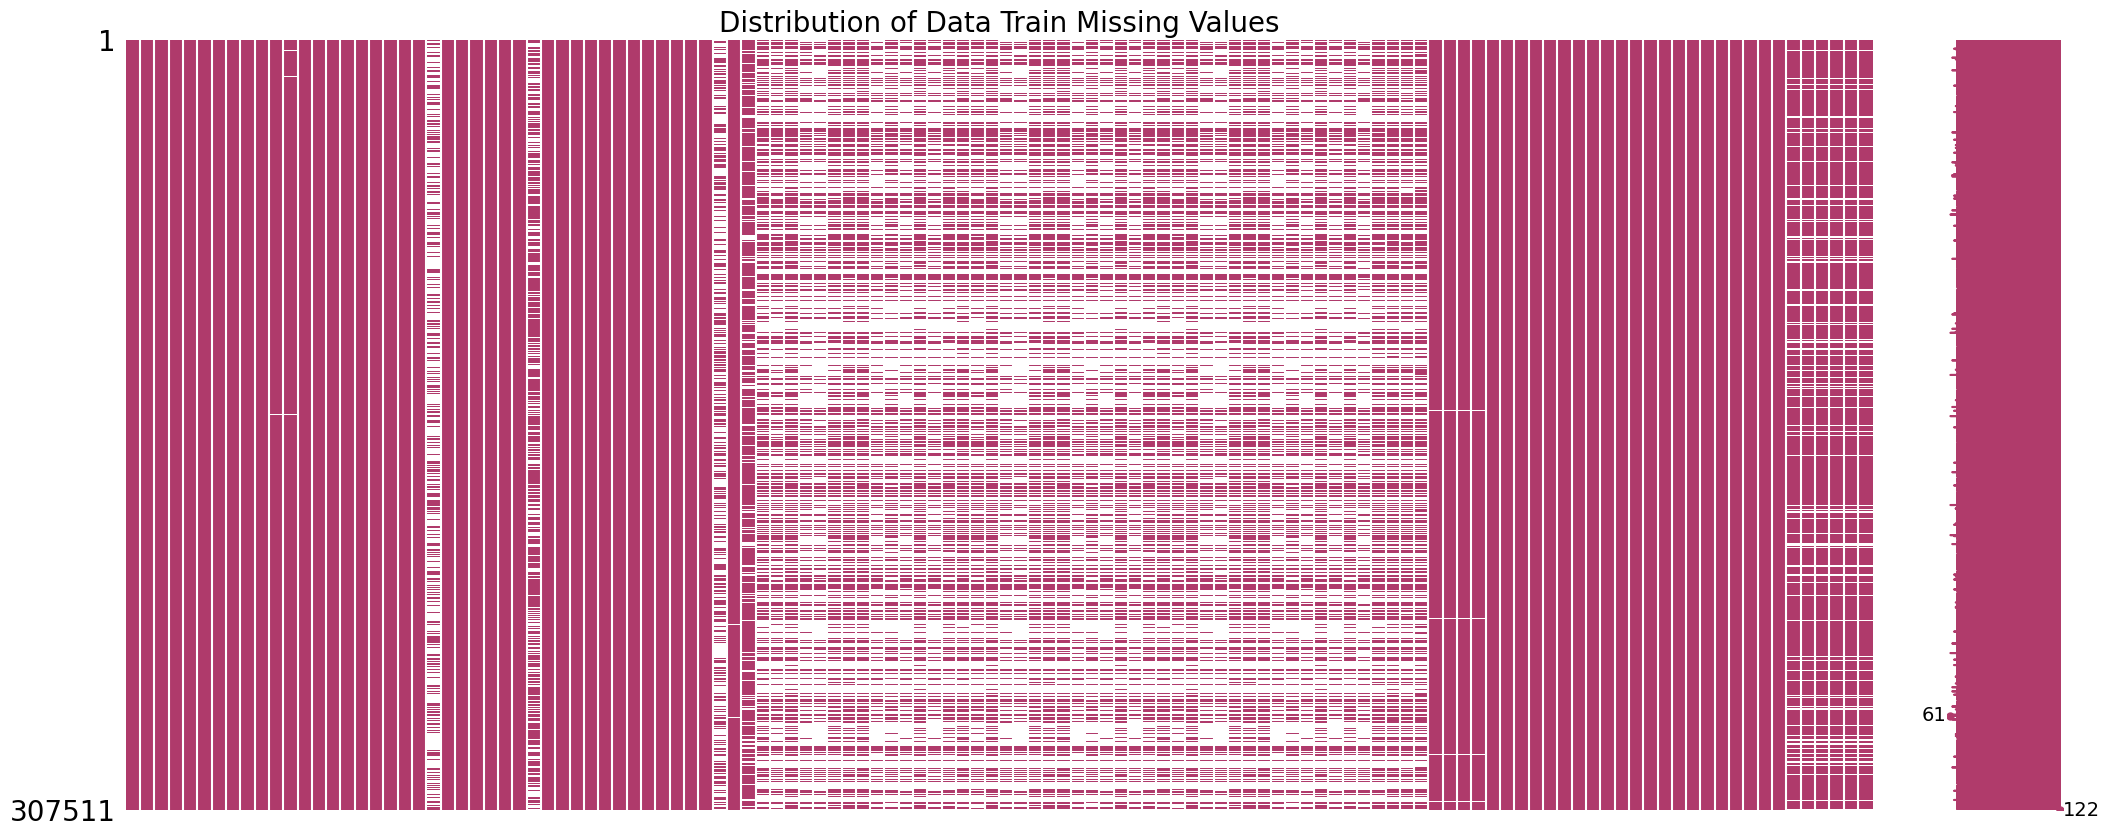

In [ ]:
msno.matrix(df_train, color=(0.69,0.23,0.42))
plt.title('Distribution of Data Train Missing Values', fontsize=20)

In [ ]:
def missing_val_test(df_test):
        # total missing values
        mis_valuess = df_test.isna().sum()
        # percentage of missing values
        mis_val_percents = 100 * df_test.isna().sum() / len(df_test)
        # make a table with the results
        mis_val_tablee = pd.concat([mis_valuess, mis_val_percents], axis=1)
        # rename the columns
        mis_val_table_ren_columns = mis_val_tablee.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        # print some summary information
        print ("Your selected dataframe has " + str(df_test.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        # return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values_test = missing_val_test(df_test)
missing_values_test.head(50)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


Text(0.5, 1.0, 'Distribution of Data Test Missing Values')

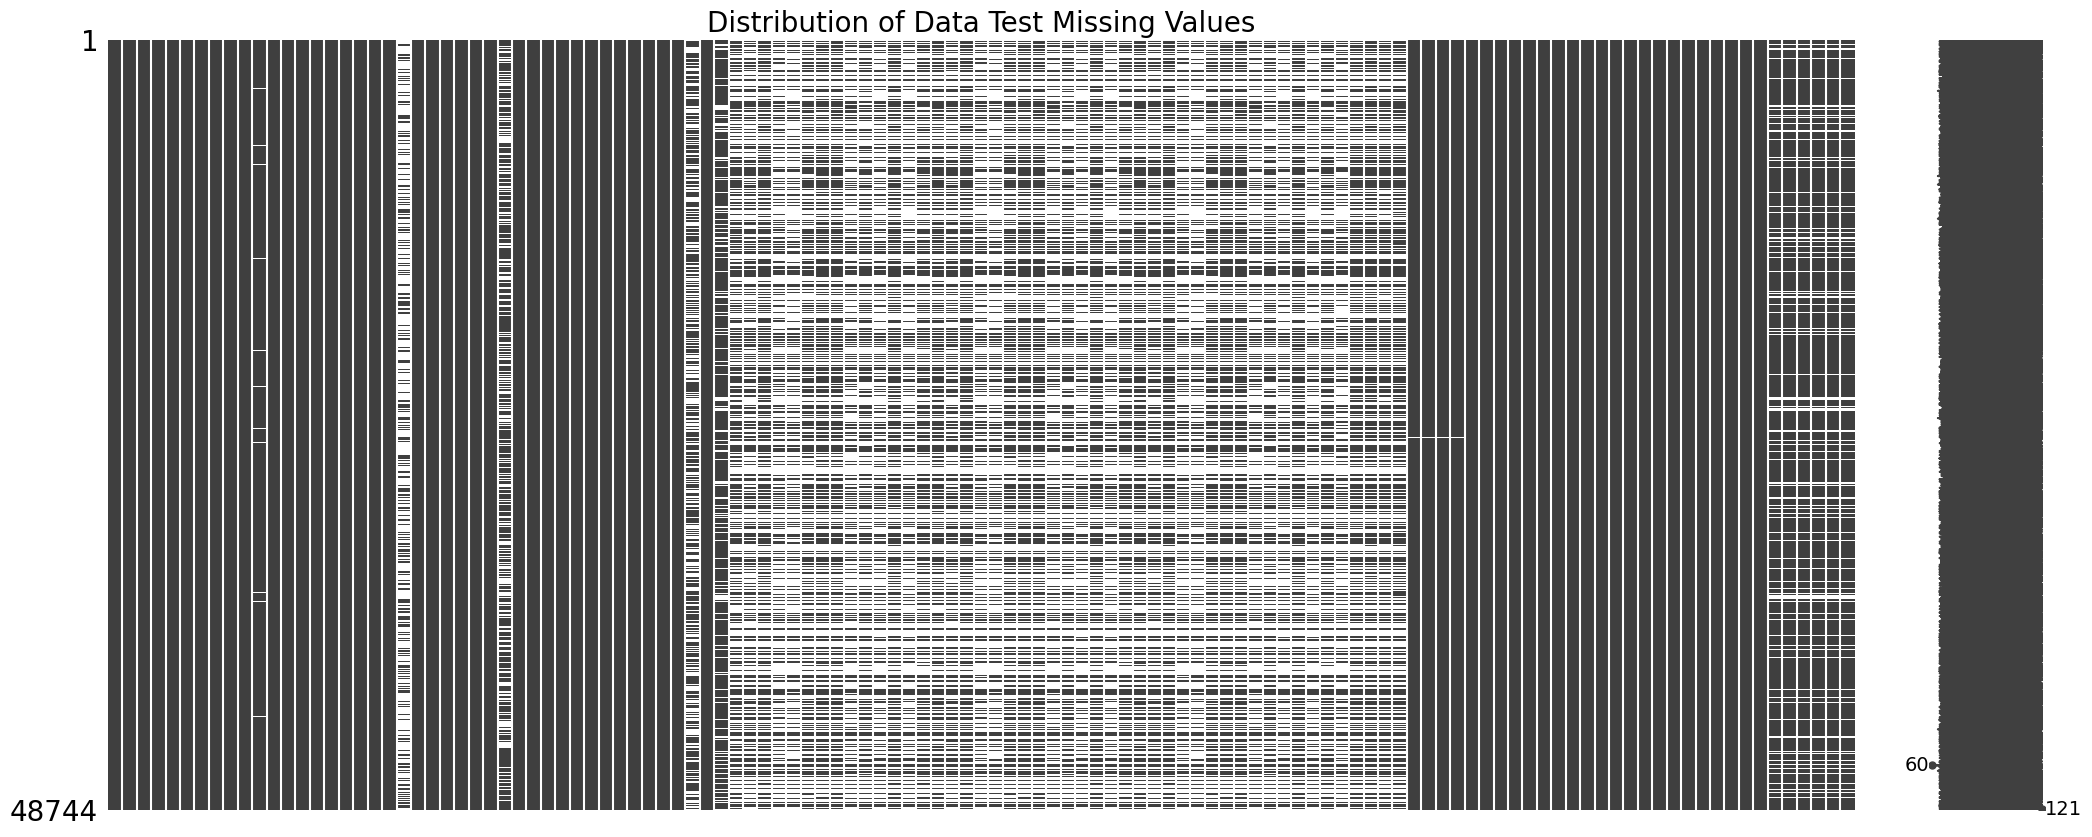

In [ ]:
msno.matrix(df_test)
plt.title('Distribution of Data Test Missing Values', fontsize=20)

##Pengelompokkan Data

In [ ]:
cats=[i for i in df_train.columns if df_train[i].dtypes == 'object']
nums=[i for i in df_train.columns if df_train[i].dtypes != 'object']

In [ ]:
df_train[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


In [ ]:
df_train[nums].shape

(307511, 106)

In [ ]:
df_train[cats].describe().T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


##Target & Gender Column Check

In [ ]:
df_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
print("Percentage: ")
(df_train["TARGET"].value_counts()/df_train["TARGET"].count())*100

Percentage: 


0    91.927118
1     8.072882
Name: TARGET, dtype: float64

In [ ]:
df_train['TARGET'].isna().sum()

0

Text(0.5, 1.0, 'Distribusi Dari Fitur TARGET')

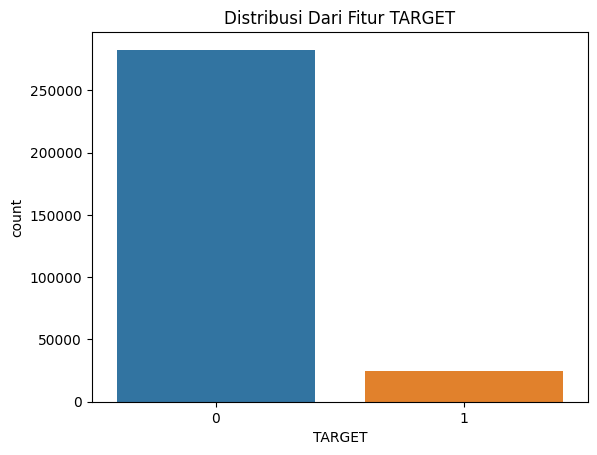

In [ ]:
sns.countplot(x=df_train['TARGET'])
plt.title('Distribusi Dari Fitur TARGET')

In [ ]:
df_train["CODE_GENDER"].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [ ]:
df_train['CODE_GENDER'].isna().sum()

0

Text(0.5, 1.0, 'Distribusi Dari Fitur Code Gender')

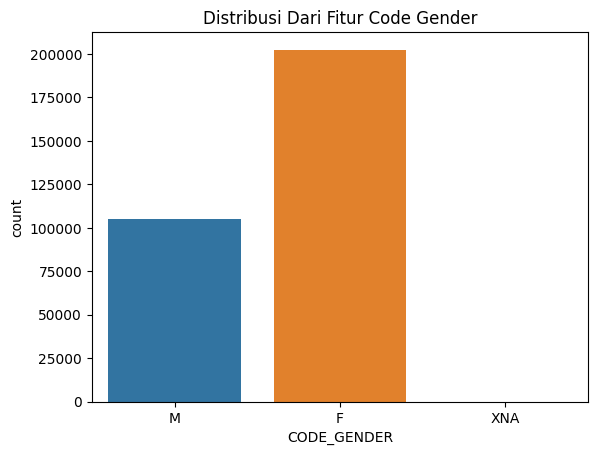

In [ ]:
sns.countplot(x=df_train['CODE_GENDER'])
plt.title('Distribusi Dari Fitur Code Gender')

In [ ]:
corr_vars = df_train.corr()['TARGET'].sort_values()
positive_corr = corr_vars[corr_vars > 0].sort_values(ascending=False).drop('TARGET')[:20]
negative_corr = corr_vars[corr_vars < 0].sort_values(ascending=True)[:20]

<ipython-input-33-0273afd5bb49>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_vars = df_train.corr()['TARGET'].sort_values()


In [ ]:
print(('Positive Correlation:\n'),positive_corr)
print(('Negative Correlation:\n'),negative_corr)

Positive Correlation:
 DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
FLAG_WORK_PHONE                0.028524
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
CNT_CHILDREN                   0.019187
CNT_FAM_MEMBERS                0.009308
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
OBS_60_CNT_SOCIAL_CIRCLE       0.009022
Name: TARGET, dtype: float64
Negative Correlation:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMP

##Outlier Check

<Axes: xlabel='AMT_INCOME_TOTAL'>

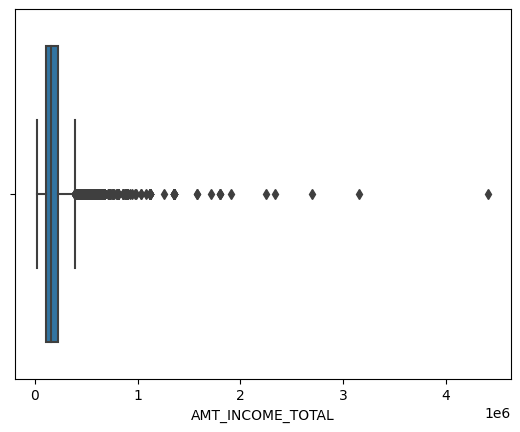

In [ ]:
sns.boxplot(x=df_test['AMT_INCOME_TOTAL'])

<Axes: xlabel='AMT_CREDIT'>

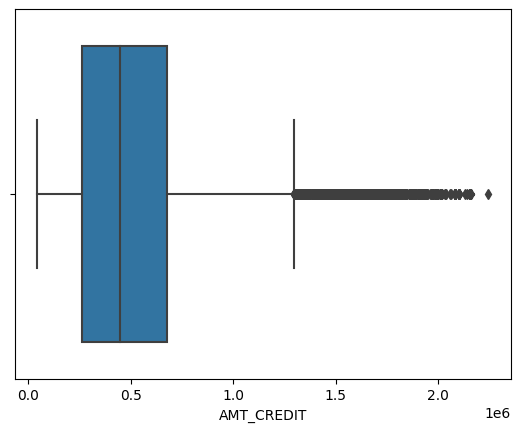

In [ ]:
sns.boxplot(x=df_test['AMT_CREDIT'])

<Axes: xlabel='AMT_ANNUITY'>

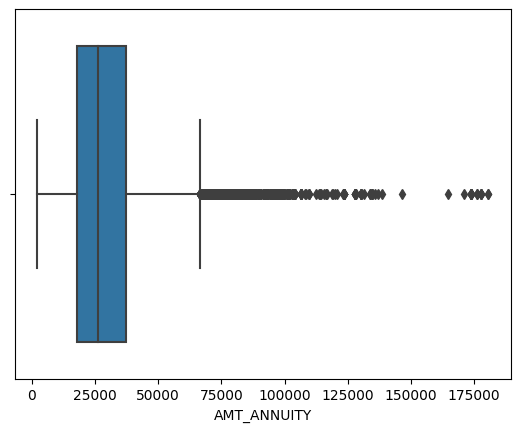

In [ ]:
sns.boxplot(x=df_test['AMT_ANNUITY'])

<Axes: xlabel='AMT_GOODS_PRICE'>

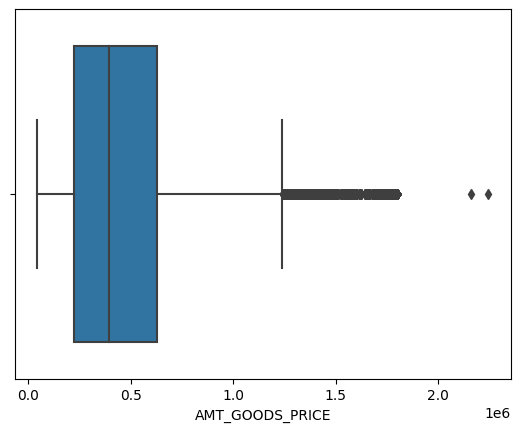

In [ ]:
sns.boxplot(x=df_test['AMT_GOODS_PRICE'])

# Data Preparation

## Handle Missing Values

DATA TRAIN - Hapus kolom dengan nilai null di atas 50%

In [ ]:
threshold = 50.0  # ambil ambang batas 50 (dalam persentase)

# hitung persentase nilai null di setiap kolom
null_percentages = 100 * df_train.isna().sum() / len(df_train)

# ambil daftar kolom yang memiliki persentase null di atas ambang batas
columns_to_drop = null_percentages[null_percentages > threshold].index

# hapus kolom-kolom yang memiliki persentase null di atas ambang batas dari df_train
df_train.drop(columns=columns_to_drop, inplace=True, axis=1)

In [ ]:
missing_values = missing_val(df_train)
missing_values.head(50)

Your selected dataframe has 81 columns.
There are 26 columns that have missing values.


,Missing Values,% of Total Values
FLOORSMAX_AVG,153020,49.8
FLOORSMAX_MODE,153020,49.8
FLOORSMAX_MEDI,153020,49.8
YEARS_BEGINEXPLUATATION_AVG,150007,48.8
YEARS_BEGINEXPLUATATION_MODE,150007,48.8
YEARS_BEGINEXPLUATATION_MEDI,150007,48.8
TOTALAREA_MODE,148431,48.3
EMERGENCYSTATE_MODE,145755,47.4
OCCUPATION_TYPE,96391,31.3
EXT_SOURCE_3,60965,19.8


DATA TEST - Hapus kolom dengan nilai null di atas 50%

In [ ]:
# hitung persentase nilai null di setiap kolom
null_percentages_test = 100 * df_test.isna().sum() / len(df_test)

# ambil daftar kolom yang memiliki persentase null di atas ambang batas
columns_to_drops = null_percentages_test[null_percentages_test > threshold].index

# hapus kolom-kolom yang memiliki persentase null di atas ambang batas dari df_test
df_test.drop(columns=columns_to_drops, inplace=True, axis=1)

In [ ]:
missing_values_test = missing_val_test(df_test)
missing_values_test.head(50)

Your selected dataframe has 92 columns.
There are 35 columns that have missing values.


,Missing Values,% of Total Values
WALLSMATERIAL_MODE,23893,49.0
APARTMENTS_AVG,23887,49.0
APARTMENTS_MODE,23887,49.0
APARTMENTS_MEDI,23887,49.0
HOUSETYPE_MODE,23619,48.5
ENTRANCES_MODE,23579,48.4
ENTRANCES_MEDI,23579,48.4
ENTRANCES_AVG,23579,48.4
LIVINGAREA_MEDI,23552,48.3
LIVINGAREA_AVG,23552,48.3


DATA TRAIN - Isi kolom numerik yang mempunyai nilai null dengan median

In [ ]:
# ambil daftar kolom numerik dengan nilai null
num_null = df_train.select_dtypes(include=np.number).columns[df_train.select_dtypes(include=np.number).isnull().any()]

# Mengisi nilai null dengan median pada setiap kolom numerik
for column in num_null:
    median_value = df_train[column].median()
    df_train[column].fillna(median_value, inplace=True)

In [ ]:
missing_values = missing_val(df_train)
missing_values.head(50)

Your selected dataframe has 81 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
EMERGENCYSTATE_MODE,145755,47.4
OCCUPATION_TYPE,96391,31.3
NAME_TYPE_SUITE,1292,0.4


DATA TEST - Isi kolom numerik yang mempunyai nilai null dengan median

In [ ]:
# ambil daftar kolom numerik dengan nilai null
num_nulls = df_test.select_dtypes(include=np.number).columns[df_test.select_dtypes(include=np.number).isnull().any()]

# Mengisi nilai null dengan median pada setiap kolom numerik
for column in num_nulls:
    median_values = df_test[column].median()
    df_test[column].fillna(median_values, inplace=True)

In [ ]:
missing_values_test = missing_val_test(df_test)
missing_values_test.head(50)

Your selected dataframe has 92 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
WALLSMATERIAL_MODE,23893,49.0
HOUSETYPE_MODE,23619,48.5
EMERGENCYSTATE_MODE,22209,45.6
OCCUPATION_TYPE,15605,32.0
NAME_TYPE_SUITE,911,1.9


DATA TRAIN - Isi kolom kategorik yang mempunyai nilai null dengan modus

In [ ]:
# ambil daftar kolom kategorik dengan nilai null
cats_null = df_train.select_dtypes(include='object').columns[df_train.select_dtypes(include='object').isnull().any()]

# Mengisi nilai null dengan modus pada setiap kolom kategorik
for column in cats_null:
    mode_value = df_train[column].mode().iloc[0]
    df_train[column].fillna(mode_value, inplace=True)

In [ ]:
missing_values = missing_val(df_train)
missing_values.head(50)

Your selected dataframe has 81 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


DATA TEST - Isi kolom kategorik yang mempunyai nilai null dengan modus

In [ ]:
# ambil daftar kolom kategorik dengan nilai null
cats_nulls = df_test.select_dtypes(include='object').columns[df_test.select_dtypes(include='object').isnull().any()]

# Mengisi nilai null dengan modus pada setiap kolom kategorik
for column in cats_nulls:
    mode_values = df_test[column].mode().iloc[0]
    df_test[column].fillna(mode_values, inplace=True)

In [ ]:
missing_values_test = missing_val_test(df_test)
missing_values_test.head(50)

Your selected dataframe has 92 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Categorical Data Encoding

DATA TRAIN - label encoding

In [ ]:
le = LabelEncoder()
#hitung jumlah counter yang telah dilabelkan
le_count = 0

for col in df_train:
  # ambil kolom di df_train dengan tipe data object/string
    if df_train[col].dtype == 'object' or df_train[col].dtype == 'string':
      # latih objek(le) untuk mempelajari kategori unik
        le.fit(df_train[col])
      # mengganti nilai menjadi yang sudah dilabelkan
        df_train[col] = le.transform(df_train[col])
      # tambah 1 setiap kolom sudah dilabelkan
        le_count += 1
        print(col)
df_train.reset_index()
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
EMERGENCYSTATE_MODE
13 columns were label encoded.


DATA TEST - label encoding

In [ ]:
#hitung jumlah counter yang telah dilabelkan
le_counts = 0

for col in df_test:
  # ambil kolom di df_test dengan tipe data object/string
    if df_test[col].dtype == 'object' or df_test[col].dtype == 'string':
      # latih objek(le) untuk mempelajari kategori unik
        le.fit(df_test[col])
      # mengganti nilai menjadi yang sudah dilabelkan
        df_test[col] = le.transform(df_test[col])
      # tambah 1 setiap kolom sudah dilabelkan
        le_counts += 1
        print(col)
df_test.reset_index()
print('%d columns were label encoded.' % le_counts)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
15 columns were label encoded.


## Memilih Feature

Gunakan korelasi analisis untuk memilih data yang akan digunakan.

In [ ]:
df_train.corr()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.000000,-0.002108,0.001654,-0.000769,0.001216,0.000703,-0.001129,-0.001820,-0.000343,-0.000431,...,0.000509,0.000167,0.001073,0.000282,-0.002517,-0.002066,0.001879,0.000328,0.000809,0.004071
TARGET,-0.002108,1.000000,-0.030896,0.054692,-0.021851,-0.006148,0.019187,-0.003982,-0.030369,-0.012815,...,-0.007952,-0.001358,0.000215,0.003709,-0.000074,0.001701,-0.001306,-0.014794,-0.005833,0.012161
NAME_CONTRACT_TYPE,0.001654,-0.030896,1.000000,-0.008613,0.004022,0.067177,0.029998,-0.003531,-0.221648,-0.241541,...,-0.007530,-0.005190,-0.007308,0.055821,0.000121,-0.004977,-0.014769,-0.014341,-0.021448,-0.049643
CODE_GENDER,-0.000769,0.054692,-0.008613,1.000000,0.345833,-0.044340,0.047403,0.074728,0.021572,0.076960,...,0.022205,0.004632,0.003258,0.023908,0.002297,0.000520,-0.002871,0.005800,-0.009681,-0.020651
FLAG_OWN_CAR,0.001216,-0.021851,0.004022,0.345833,1.000000,-0.002817,0.102023,0.083383,0.116225,0.141587,...,-0.000097,0.002184,0.007299,0.006741,0.003678,0.001514,0.002822,0.023536,-0.004081,-0.026124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,-0.002066,0.001701,-0.004977,0.000520,0.001514,-0.009080,0.000107,0.003481,0.005028,0.002286,...,0.012956,0.001154,0.000078,-0.001076,0.230873,1.000000,0.218370,-0.002750,-0.001551,0.000742
AMT_REQ_CREDIT_BUREAU_WEEK,0.001879,-0.001306,-0.014769,-0.002871,0.002822,0.005801,-0.001083,0.003950,0.001634,0.013494,...,-0.003666,-0.001006,-0.001239,-0.000057,0.006422,0.218370,1.000000,-0.007423,-0.007466,0.029318
AMT_REQ_CREDIT_BUREAU_MON,0.000328,-0.014794,-0.014341,0.005800,0.023536,-0.006163,-0.007983,0.026746,0.055536,0.037171,...,-0.000179,-0.002230,0.002177,-0.003489,0.002973,-0.002750,-0.007423,1.000000,0.005318,0.013708
AMT_REQ_CREDIT_BUREAU_QRT,0.000809,-0.005833,-0.021448,-0.009681,-0.004081,0.012013,-0.004913,0.007924,0.020379,0.010685,...,-0.003362,-0.001079,0.000034,-0.002066,0.000725,-0.001551,-0.007466,0.005318,1.000000,0.095723


Lihat feature-feature yang memiliki korelasi tertinggi (lebih dari 0.04) dengan feature TARGET

In [ ]:
#melihat korelasi tertinggi
corr=df_train.corr()

high_corr_features=corr.index[(corr['TARGET'])>0.05]
print(f'highly correlated feature:\n',high_corr_features)
print(f'\nNo. of highly correlated features:',len(high_corr_features))

highly correlated feature:
 Index(['TARGET', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH',
       'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

No. of highly correlated features: 9


Didapatkan 9 feature yaitu:


1.   TARGET = Variabel target (1 - klien dengan kesulitan membayar, 0 - kasus lainnya)
2.   CODE_GENDER = Variabel gender berisi F (Female) dan M (Male) yang telah di-encode menjadi 0 = F dan 1 = M
3.   NAME_EDUCATION_TYPE = Berisi tingkat pendidikan tertinggi yang dicapai klien
5. DAYS_BIRTH = Usia klien dalam hari pada saat melakukan peminjaman
7. DAYS_ID_PUBLISH = Berapa hari sebelum klien mengubah dokumen identitas yang dia gunakan untuk pinjaman
7. REGION_RATING_CLIENT = Peringkat untuk wilayah tempat tinggal klien (1,2,3)
8. REGION_RATING_CLIENT_W_CITY = Peringkat untuk wilayah tempat klien tinggal dengan mempertimbangkan kota (1,2,3)
10. REG_CITY_NOT_WORK_CITY = Berisi tanda jika alamat tetap klien tidak cocok dengan alamat kantor (1=berbeda, 0=sama, di tingkat kota)
11. DAYS_LAST_PHONE_CHANGE = Banyak hari sebelum klien mengganti ponsel



## Mengganti Value Negatif

In [ ]:
df_train[['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']] = df_train[['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']].apply(lambda x: abs(x))
df_train[['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']].head()

,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
0,9461,2120,1134.0
1,16765,291,828.0
2,19046,2531,815.0
3,19005,2437,617.0
4,19932,3458,1106.0


In [ ]:
df_test[['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']] = df_test[['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']].apply(lambda x: abs(x))
df_test[['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']].head()

,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
0,19241,812,1740.0
1,18064,1623,0.0
2,20038,3503,856.0
3,13976,4208,1805.0
4,13040,4262,821.0


## Handle Outliers

DATA TRAIN - cek outliers dengan boxplot, handle dengan IQR

<Axes: xlabel='DAYS_LAST_PHONE_CHANGE'>

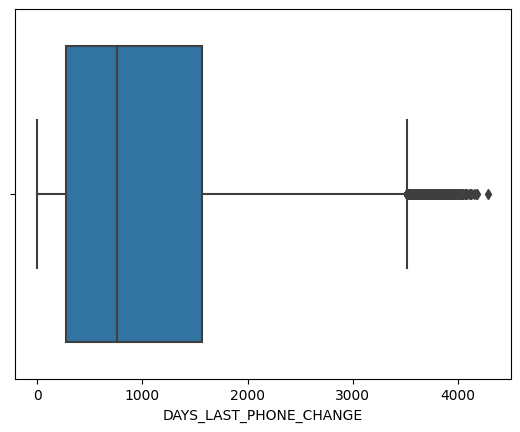

In [ ]:
sns.boxplot(x=df_train['DAYS_LAST_PHONE_CHANGE'])

In [ ]:
def handle_outliers(data, columns):
    for column in columns:
        Q1 = np.percentile(data[column], 25)
        Q3 = np.percentile(data[column], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), np.median(data[column]), data[column])

# Daftar kolom yang akan diatasi outlier
outlier_columns = ['DAYS_LAST_PHONE_CHANGE']

# Mengatasi outlier pada semua kolom dalam daftar outlier_columns
handle_outliers(df_train, outlier_columns)

<Axes: xlabel='DAYS_LAST_PHONE_CHANGE'>

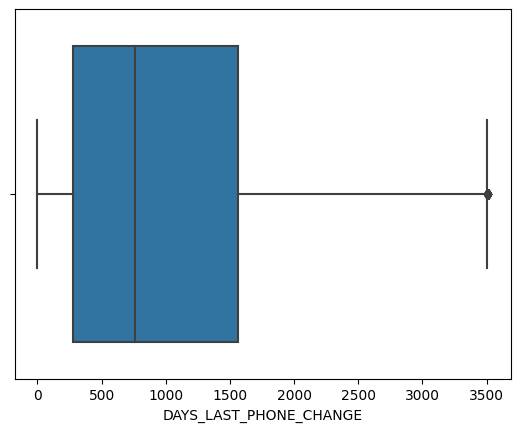

In [ ]:
sns.boxplot(x=df_train['DAYS_LAST_PHONE_CHANGE'])

DATA TEST - cek outliers dengan boxplot, handle dengan IQR

<Axes: xlabel='DAYS_LAST_PHONE_CHANGE'>

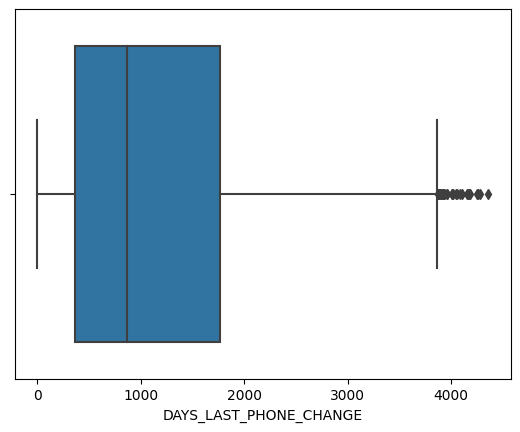

In [ ]:
sns.boxplot(x=df_test['DAYS_LAST_PHONE_CHANGE'])

In [ ]:
# Mengatasi outlier pada semua kolom dalam daftar outlier_columns
handle_outliers(df_test, outlier_columns)

<Axes: xlabel='DAYS_LAST_PHONE_CHANGE'>

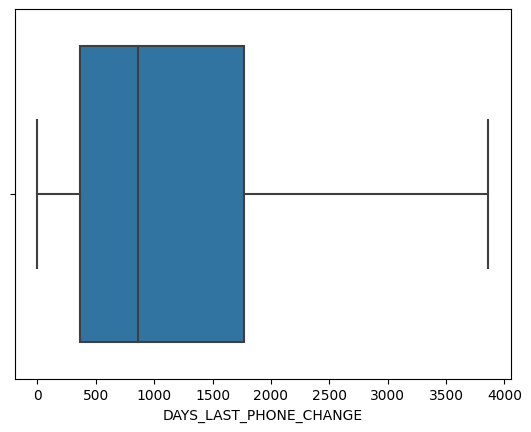

In [ ]:
sns.boxplot(x=df_test['DAYS_LAST_PHONE_CHANGE'])

# Data Analysis

## PRE-MODELING




In [ ]:
app_train=df_train[high_corr_features]

In [ ]:
gfg2_csv_data = app_train.to_csv('hasil_train.csv', index = False)
print('\nCSV String:\n', gfg2_csv_data)


CSV String:
 None


In [ ]:
app_test=df_test[high_corr_features.drop('TARGET')]

In [ ]:
gfg_csv_data = app_test.to_csv('hasil_test.csv', index = False)
print('\nCSV String:\n', gfg_csv_data)


CSV String:
 None


In [ ]:
x=df_train[high_corr_features.drop('TARGET')]
y=df_train[['TARGET']]

print(y['TARGET'].value_counts())

#Lakukan undersampling
from imblearn.under_sampling import NearMiss

nm = NearMiss(version=3, n_neighbors_ver3=3)
x, y = nm.fit_resample(x, y)

print(y['TARGET'].value_counts())

0    282686
1     24825
Name: TARGET, dtype: int64
0    24825
1    24825
Name: TARGET, dtype: int64


In [ ]:
df_test=df_test[high_corr_features.drop('TARGET')]

In [ ]:
x.head()

,CODE_GENDER,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE
0,0,4,22530,1259,1,1,0,3409.0
1,1,4,22246,117,2,2,0,2957.0
2,0,1,22111,871,1,1,0,3279.0
3,0,4,16077,6208,2,2,1,2984.0
4,0,1,16243,6116,2,2,1,3140.0


In [ ]:
y['TARGET'].value_counts()

0    24825
1    24825
Name: TARGET, dtype: int64

In [ ]:
df_test.head()

,CODE_GENDER,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE
0,0,1,19241,812,2,2,0,1740.0
1,1,4,18064,1623,2,2,0,0.0
2,1,1,20038,3503,2,2,0,856.0
3,0,4,13976,4208,2,2,0,1805.0
4,1,4,13040,4262,2,2,1,821.0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)
print( x_train.shape, x_test.shape)
print(y_test.shape)

(37237, 8) (12413, 8)
(12413, 1)


In [ ]:
#gunakan standard scaler untuk mengendalikan nilai vektor yang berulang
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
test_df=scaler.fit_transform(df_test)

## LOGISTIC REGRESSION

### Model Logistic Regression

In [ ]:
LR = LogisticRegression()

In [ ]:
LR.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

### Prediksi Model

In [ ]:
y_pred = LR.predict(x_test)
print("Predictions:\n\n", y_pred)
print("\nReal values:\n\n", y_test)

Predictions:

 [0 0 0 ... 1 0 1]

Real values:

        TARGET
9030        0
7846        0
46608       1
13521       0
30409       1
...       ...
11826       0
16044       0
20393       0
39685       1
15960       0

[12413 rows x 1 columns]


In [ ]:
report_LR = classification_report(y_test, y_pred)
print(report_LR)

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      6207
           1       0.62      0.65      0.63      6206

    accuracy                           0.63     12413
   macro avg       0.63      0.63      0.63     12413
weighted avg       0.63      0.63      0.63     12413



### AUC Score & ROC Curve

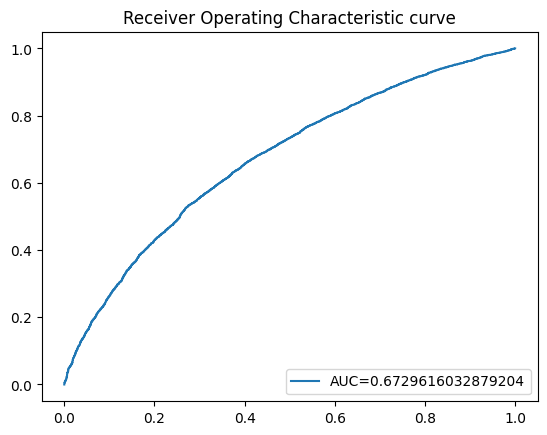

In [ ]:
prediction_prob = LR.predict_proba(x_test)[::,1]
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test,  prediction_prob)
auc_LR = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr_lr,tpr_lr,label="AUC="+str(auc_LR))
plt.legend(loc=4)
plt.show()

### Evaluation Metrics

In [ ]:
#Mengecek akurasi model
akurasi_LR = LR.score(x_test,y_test)
mae_LR = metrics.mean_absolute_error(y_test, y_pred)
mse_LR = metrics.mean_squared_error(y_test, y_pred)
rmse_LR = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
cross_score_LR = round((cross_val_score(LR, x_train, y_train, cv=3, scoring='accuracy').mean())*100, 2)

print('Akurasi:', akurasi_LR)
print('MAE:', mae_LR)
print('MSE:', mse_LR)
print('RMSE:', rmse_LR)
print("Cross validation:", cross_score_LR, '%\n')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Akurasi: 0.62724562958189
MAE: 0.37275437041811005
MSE: 0.37275437041811005
RMSE: 0.6105361335892496
Cross validation: 61.42 %



### Model Implementation

In [ ]:
app_test_LR = df_test.copy()

In [ ]:
y_pred_test = LR.predict(app_test_LR)
app_test_LR['TARGET'] = y_pred_test.astype(int)
print(app_test_LR['TARGET'])

0        0
1        0
2        0
3        0
4        0
        ..
48739    0
48740    0
48741    0
48742    0
48743    0
Name: TARGET, Length: 48744, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
app_test_LR['TARGET'].value_counts()

0    48744
Name: TARGET, dtype: int64

## DECISION TREE

### Model Decision Tree

In [ ]:
DT = DecisionTreeClassifier(criterion='gini')

In [ ]:
DT.fit(x_train, y_train)

DecisionTreeClassifier()

### Prediksi Model

In [ ]:
y_pred = DT.predict(x_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0 0 1 ... 0 0 1] 

Real values:

        TARGET
9030        0
7846        0
46608       1
13521       0
30409       1
...       ...
11826       0
16044       0
20393       0
39685       1
15960       0

[12413 rows x 1 columns]


In [ ]:
report_DT = classification_report(y_test, y_pred)
print(report_DT)

              precision    recall  f1-score   support

           0       0.63      0.64      0.63      6207
           1       0.63      0.62      0.62      6206

    accuracy                           0.63     12413
   macro avg       0.63      0.63      0.63     12413
weighted avg       0.63      0.63      0.63     12413



### AUC Score & ROC Curve

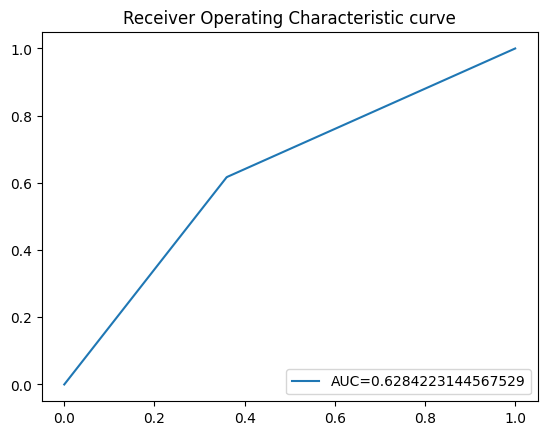

In [ ]:
prediction_prob = DT.predict_proba(x_test)[::,1]
fpr_dt, tpr_dt, _ = metrics.roc_curve(y_test,  prediction_prob)
auc_DT = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr_dt,tpr_dt,label="AUC="+str(auc_DT))
plt.legend(loc=4)
plt.show()

### Evaluation Metrics

In [ ]:
#Mengecek akurasi model
akurasi_DT = DT.score(x_test,y_test)
mae_DT = metrics.mean_absolute_error(y_test, y_pred)
mse_DT = metrics.mean_squared_error(y_test, y_pred)
rmse_DT = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
cross_score_DT = round((cross_val_score(DT, x_train, y_train, cv=3, scoring='accuracy').mean())*100, 2)

print('Akurasi:', akurasi_DT)
print('MAE:', mae_DT)
print('MSE:', mse_DT)
print('RMSE:', rmse_DT)
print("Cross validation:", cross_score_DT, '%\n')

Akurasi: 0.6284540401192298
MAE: 0.37154595988077016
MSE: 0.37154595988077016
RMSE: 0.609545699583526
Cross validation: 63.1 %



### Model Implementation

In [ ]:
app_test_DT = df_test.copy()

In [ ]:
y_pred_test = DT.predict(app_test_DT)
app_test_DT['TARGET'] = y_pred_test.astype(int)
print(app_test_DT['TARGET'])

0        0
1        0
2        1
3        0
4        1
        ..
48739    0
48740    1
48741    0
48742    1
48743    0
Name: TARGET, Length: 48744, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
app_test_DT['TARGET'].value_counts()

0    31178
1    17566
Name: TARGET, dtype: int64

## RANDOM FOREST

### Model Random Forest

In [ ]:
RF = RandomForestClassifier()

In [ ]:
RF.fit(x_train, y_train)

<ipython-input-93-90c9a5afc842>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(x_train, y_train)


RandomForestClassifier()

### Prediksi Model

In [ ]:
y_pred = RF.predict(x_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0 0 0 ... 0 0 0] 

Real values:

        TARGET
9030        0
7846        0
46608       1
13521       0
30409       1
...       ...
11826       0
16044       0
20393       0
39685       1
15960       0

[12413 rows x 1 columns]


In [ ]:
report_RF = classification_report(y_test, y_pred)
print(report_RF)

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      6207
           1       0.71      0.62      0.66      6206

    accuracy                           0.68     12413
   macro avg       0.68      0.68      0.68     12413
weighted avg       0.68      0.68      0.68     12413



### AUC Score & ROC Curve

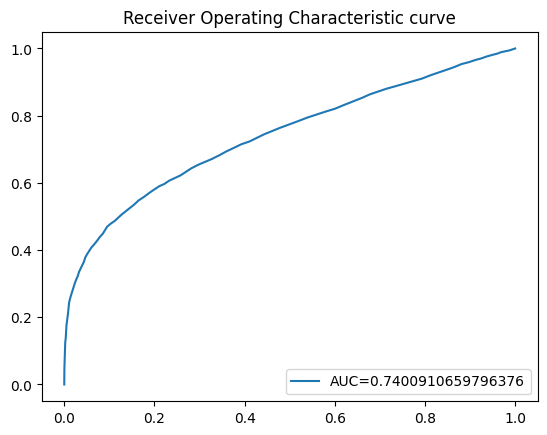

In [ ]:
prediction_prob = RF.predict_proba(x_test)[::,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test,  prediction_prob)
auc_RF = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr_rf,tpr_rf,label="AUC="+str(auc_RF))
plt.legend(loc=4)
plt.show()

### Evaluation Metrics

In [ ]:
#Mengecek akurasi model
akurasi_RF = RF.score(x_test,y_test)
mae_RF = metrics.mean_absolute_error(y_test, y_pred)
mse_RF = metrics.mean_squared_error(y_test, y_pred)
rmse_RF = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
cross_score_RF = round((cross_val_score(RF, x_train, y_train, cv=3, scoring='accuracy').mean())*100, 2)


print('Akurasi:', akurasi_RF)
print('MAE:', mae_RF)
print('MSE:', mse_RF)
print('RMSE:', rmse_RF)
print("Cross validation:", cross_score_RF)



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Akurasi: 0.6822685893820994
MAE: 0.3177314106179006
MSE: 0.3177314106179006
RMSE: 0.5636766897946913
Cross validation: 67.86


### Model Implementation

In [ ]:
app_test_RF = df_test.copy()

In [ ]:
y_pred_test = RF.predict(app_test_RF)
app_test_RF['TARGET'] = y_pred_test.astype(int)
print(app_test_RF['TARGET'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0        0
1        0
2        0
3        0
4        0
        ..
48739    0
48740    0
48741    0
48742    0
48743    0
Name: TARGET, Length: 48744, dtype: int64


In [ ]:
app_test_RF['TARGET'].value_counts()

0    48743
1        1
Name: TARGET, dtype: int64

In [ ]:
app_test_RF[app_test_RF['TARGET']==1]

,CODE_GENDER,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,TARGET
34791,1,4,16460,0,1,1,0,0.0,1


# Data Evaluation

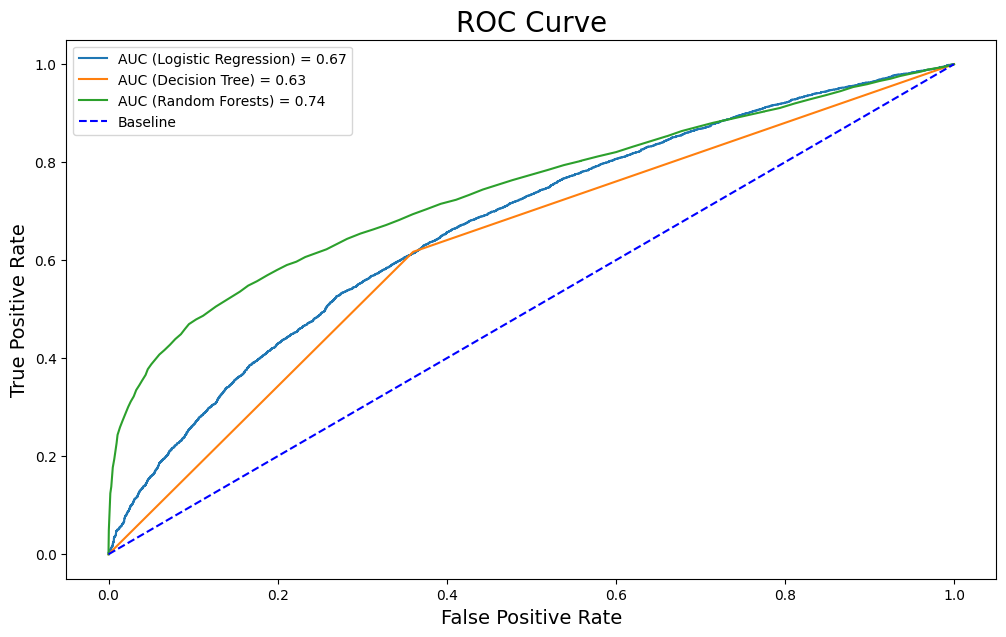

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_LR:.2f}')
plt.plot(fpr_dt, tpr_dt, label=f'AUC (Decision Tree) = {auc_DT:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forests) = {auc_RF:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();

In [ ]:
data = {'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
        'Akurasi': [akurasi_LR, akurasi_DT, akurasi_RF],
        'MAE' : [mae_LR, mae_DT, mae_RF],
        'MSE' : [mse_LR, mse_DT, mse_RF],
        'RMSE': [rmse_LR, rmse_DT, rmse_RF],
        'Cross Validation' :[cross_score_LR, cross_score_DT, cross_score_RF],
        'AUC Score': [auc_LR, auc_DT, auc_RF]
        }

df = pd.DataFrame(data)

df.head()

,Model,Akurasi,MAE,MSE,RMSE,Cross Validation,AUC Score
0,Logistic Regression,0.627246,0.372754,0.372754,0.610536,61.42,0.672962
1,Decision Tree,0.628454,0.371546,0.371546,0.609546,63.10,0.628422
2,Random Forest,0.682269,0.317731,0.317731,0.563677,67.86,0.740091


In [ ]:
# Dari hasil evaluasi model terbaik adalah Random Forest
app_test_RF

,CODE_GENDER,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,TARGET
0,0,1,19241,812,2,2,0,1740.0,0
1,1,4,18064,1623,2,2,0,0.0,0
2,1,1,20038,3503,2,2,0,856.0,0
3,0,4,13976,4208,2,2,0,1805.0,0
4,1,4,13040,4262,2,2,1,821.0,0
...,...,...,...,...,...,...,...,...,...
48739,0,4,19970,3399,3,3,0,684.0,0
48740,0,4,11186,3003,2,2,1,0.0,0
48741,0,4,15922,1504,2,2,0,838.0,0
48742,1,1,13968,1364,2,2,1,2308.0,0


[-0.37432277  0.24350292  0.23741672  0.16835063 -0.12246545  0.08113944
  0.06043203  0.02459626]


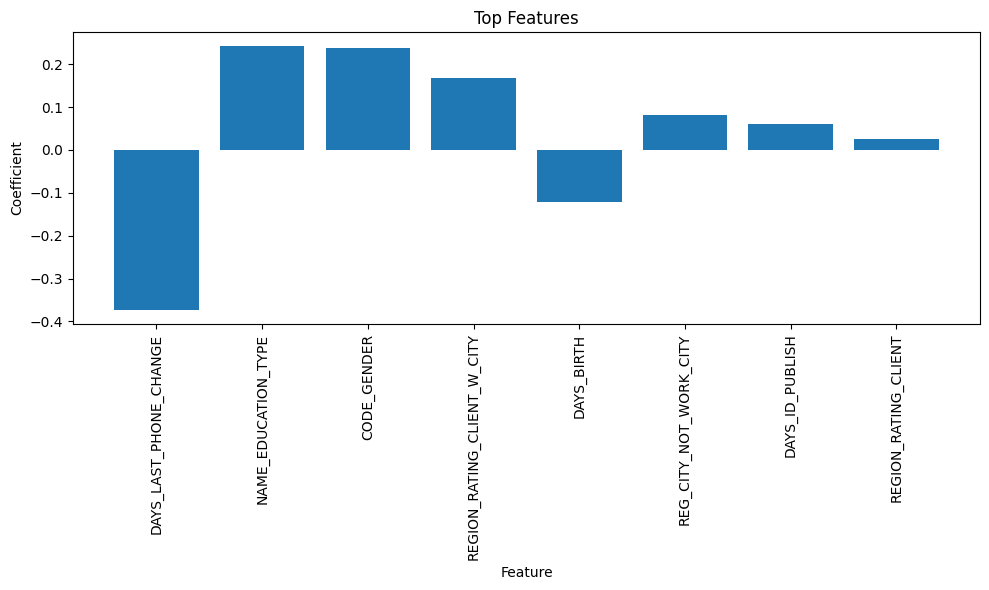

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already fitted the logistic regression model
# and obtained the coefficients
coefficients = RF.coef_[0]
feature_names = np.array(['CODE_GENDER',	'NAME_EDUCATION_TYPE',	'DAYS_BIRTH',	'DAYS_ID_PUBLISH',	'REGION_RATING_CLIENT',	'REGION_RATING_CLIENT_W_CITY',	'REG_CITY_NOT_WORK_CITY',	'DAYS_LAST_PHONE_CHANGE'])  # Replace with actual feature names

# Sort the coefficients and feature names in descending order of importance
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

print(sorted_coefficients)
# Create a bar plot to visualize the top features
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_coefficients)), sorted_coefficients)
plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top Features')
plt.tight_layout()
plt.show()

In [ ]:
data = {'Feature Name': sorted_feature_names,
        'Koef': sorted_coefficients}

In [ ]:
dt = pd.DataFrame(data)

dt.head()

,Feature Name,Koef
0,DAYS_LAST_PHONE_CHANGE,-0.374323
1,NAME_EDUCATION_TYPE,0.243503
2,CODE_GENDER,0.237417
3,REGION_RATING_CLIENT_W_CITY,0.168351
4,DAYS_BIRTH,-0.122465


In [ ]:
gfg3_csv_data = app_test_RF.to_csv('hasil_RF.csv', index = False)
print('\nCSV String:\n', gfg3_csv_data)


CSV String:
 None


In [ ]:
gfg3_csv_data = df.to_csv('evaluation.csv', index = False)
print('\nCSV String:\n', gfg3_csv_data)


CSV String:
 None


In [ ]:
gfg3_csv_data = dt.to_csv('koef.csv', index = False)
print('\nCSV String:\n', gfg3_csv_data)


CSV String:
 None


In [ ]:
import pickle
pickle.dump(RF, open('model.pkl', 'wb'))